# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
#PATH_TO_DATA = "../input/bi-2021-ml-competitions-dota2"

#df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
#                                             "train_data.csv"), 
#                                    index_col="match_id_hash")
#df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
#                                            "train_targets.csv"), 
#                                   index_col="match_id_hash")
df_train_features = pd.read_csv("train_data.csv", index_col="match_id_hash")
df_train_targets = pd.read_csv("train_targets.csv", index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

Wall time: 16.7 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [12]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [11]:
df_test_features = pd.read_csv("test_data.csv", index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [14]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-08_19-28-10.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [9]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [16]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

Wall time: 1min 14s


In [17]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [18]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [77]:
with open("train_raw_data.jsonl") as fin:
    # прочтем 419 строку
    for i in range(415):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [78]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(2, 5, 3)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

In [86]:
print(match.keys())
print(match['objectives'])
print(match["players"][3])

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])
[{'time': 269.701, 'type': 'CHAT_MESSAGE_FIRSTBLOOD', 'slot': 2, 'key': 6, 'player_slot': 2}, {'time': 718.924, 'type': 'CHAT_MESSAGE_TOWER_DENY', 'team': 60, 'slot': 6, 'player_slot': 129}, {'time': 891.216, 'type': 'CHAT_MESSAGE_TOWER_DENY', 'team': 60, 'slot': 7, 'player_slot': 130}, {'time': 903.746, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': 1, 'player_slot': 1}, {'time': 1111.162, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': -1}, {'time': 1337.44, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': 3, 'player_slot': 3}, {'time': 1390.227, 'type': 'CHAT_MESSAGE_ROSHAN_KILL', 'team': 2}, {'time': 1390.427, 'type': 'CHAT_MESSAGE_AEGIS', 'slot': 3, 'player_slot': 3}, {'time': 1465.476, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': 3, 'player_slot': 3}, {'time': 1505.599, 'type': 'CHAT_MESSAGE_TOWER_KILL', 'team': 2, 'slot': 0, 'p

{'player_slot': 3, 'hero_id': 93, 'hero_name': 'npc_dota_hero_slark', 'account_id_hash': '736d53353484cbd6166e0f0b4847136a', 'ability_upgrades': [{'ability': 5496, 'time': 364, 'level': 1}, {'ability': 5495, 'time': 399, 'level': 2}, {'ability': 5494, 'time': 444, 'level': 3}, {'ability': 5494, 'time': 533, 'level': 4}, {'ability': 5494, 'time': 600, 'level': 5}, {'ability': 5497, 'time': 663, 'level': 6}, {'ability': 5494, 'time': 780, 'level': 7}, {'ability': 5495, 'time': 871, 'level': 8}, {'ability': 5495, 'time': 976, 'level': 9}, {'ability': 6029, 'time': 1101, 'level': 10}, {'ability': 5495, 'time': 1184, 'level': 11}, {'ability': 5497, 'time': 1245, 'level': 12}, {'ability': 5496, 'time': 1314, 'level': 13}, {'ability': 5496, 'time': 1382, 'level': 14}, {'ability': 5907, 'time': 1470, 'level': 15}], 'obs_placed': 0, 'sen_placed': 1, 'creeps_stacked': 1, 'camps_stacked': 1, 'rune_pickups': 7, 'firstblood_claimed': 0, 'teamfight_participation': 0.594, 'towers_killed': 2, 'roshans

In [25]:
for col in df_test_features:
    print(col)

game_time
game_mode
lobby_type
objectives_len
chat_len
r1_hero_id
r1_kills
r1_deaths
r1_assists
r1_denies
r1_gold
r1_lh
r1_xp
r1_health
r1_max_health
r1_max_mana
r1_level
r1_x
r1_y
r1_stuns
r1_creeps_stacked
r1_camps_stacked
r1_rune_pickups
r1_firstblood_claimed
r1_teamfight_participation
r1_towers_killed
r1_roshans_killed
r1_obs_placed
r1_sen_placed
r2_hero_id
r2_kills
r2_deaths
r2_assists
r2_denies
r2_gold
r2_lh
r2_xp
r2_health
r2_max_health
r2_max_mana
r2_level
r2_x
r2_y
r2_stuns
r2_creeps_stacked
r2_camps_stacked
r2_rune_pickups
r2_firstblood_claimed
r2_teamfight_participation
r2_towers_killed
r2_roshans_killed
r2_obs_placed
r2_sen_placed
r3_hero_id
r3_kills
r3_deaths
r3_assists
r3_denies
r3_gold
r3_lh
r3_xp
r3_health
r3_max_health
r3_max_mana
r3_level
r3_x
r3_y
r3_stuns
r3_creeps_stacked
r3_camps_stacked
r3_rune_pickups
r3_firstblood_claimed
r3_teamfight_participation
r3_towers_killed
r3_roshans_killed
r3_obs_placed
r3_sen_placed
r4_hero_id
r4_kills
r4_deaths
r4_assists
r4_denies


Информация о количестве использованных способностей:

In [21]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

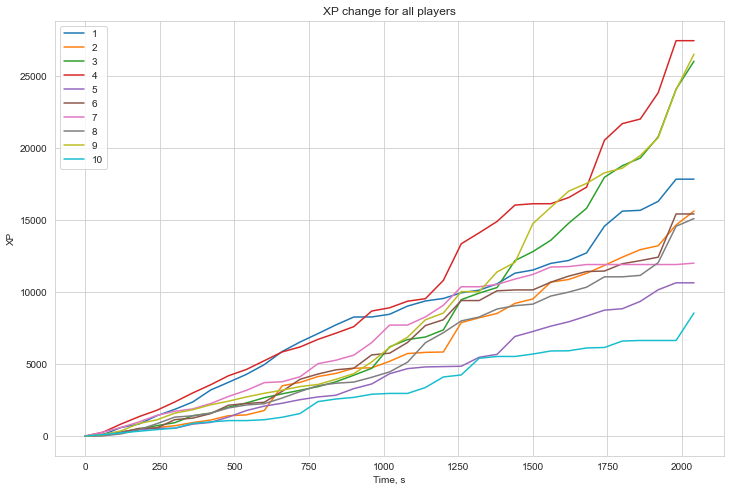

In [22]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [10]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [14]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [15]:
# Скопируем таблицу с признаками 
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, "train_raw_data.jsonl")

In [30]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [29]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 1min 49s


In [30]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

Сначала переберем все модели которые были в предыдущем дз.

In [ ]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()


base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

vth = VotingClassifier(estimators=base_models, voting='hard')
vts = VotingClassifier(estimators=base_models, voting='soft')
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, vth, vts]:#, voting_hard, voting_soft]:
    scores = cross_val_score(model, df_train_features_extended.values, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.6996785313601833
RandomForestClassifier: 0.7731839649253668
CatBoostClassifier: 0.8012284159085091
ExtraTreesClassifier: 0.7797525172503896
KNeighborsClassifier: 0.7131076168293383


In [ ]:
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

for model in [svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]:#, voting_hard, voting_soft]:
    scores = cross_val_score(model, df_train_features_extended.values, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{model.__class__.__name__}: {scores.mean()}")

In [16]:
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

for model in [lr]:#, voting_hard, voting_soft]:
    scores = cross_val_score(model, df_train_features_extended.values, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{model.__class__.__name__}: {scores.mean()}")

LogisticRegression: 0.8074803532630705


In [32]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
for model in [cat]:#, voting_hard, voting_soft]:
    scores = cross_val_score(model, df_train_features_extended.values, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{model.__class__.__name__}: {scores.mean()}")

CatBoostClassifier: 0.8012284159085091


Пошлем эти результаты как первую посылку.

In [33]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED).fit(df_train_features_extended.values, y)

In [36]:
df_test_features = pd.read_csv("test_data.csv", index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, "test_raw_data.jsonl")

In [38]:
X_test = df_test_features_extended.values

y_test_pred = cat.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [39]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-08_20-40-53.csv


In [19]:
lr = LogisticRegression(solver='liblinear', max_iter=10000).fit(df_train_features_extended.values, y)
df_test_features = pd.read_csv("test_data.csv", index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, "test_raw_data.jsonl")
X_test = df_test_features_extended.values

y_test_pred = lr.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))


Файл посылки сохранен, как: submission_2023-04-08_23-42-56.csv


логистическая регрессия оказалась еще лучше, берем ее

In [11]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
        for i in range(10):
            player = match["players"][i]
            if player['deaths'] == 0:
                kda = 0
            else: 
                kda = (player["assists"] + player["kills"])/player["deaths"]
            if i < 5:
                    df_features.loc[match_id_hash, "r" + str(i+1) + '_kda'] = kda
            else:
                    df_features.loc[match_id_hash, "d" + str(i - 4) + '_kda'] = kda
                    
                

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        #добавила KDA для каждого персонажа

In [12]:
df_train_features_extended = df_train_features.copy()
add_new_features(df_train_features_extended, "train_raw_data.jsonl")

lr = LogisticRegression(solver='liblinear', max_iter=10000).fit(df_train_features_extended.values, y)
df_test_features = pd.read_csv("test_data.csv", index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, "test_raw_data.jsonl")
X_test = df_test_features_extended.values

y_test_pred = lr.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))


Файл посылки сохранен, как: submission_2023-04-09_00-29-41.csv


Эта посылка оказалась хуже предыдущей, поэтому эти данные пока выкидываем.

In [16]:
a = read_matches("test_raw_data.jsonl")

TypeError: 'generator' object is not subscriptable

In [95]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        r_aeigs = 0
        d_aeigs = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_AEGIS":
                if objective["player_slot"] < 6:
                    r_aeigs += 1
                else:
                    d_aeigs += 1
                    
        Kr = 0
        Kd = 0
        Dr = 0
        Dd = 0
        Ar = 0
        Ad = 0
        AUr = 0
        AUd = 0
        for i in range(10):
            player = match["players"][i]
            if i < 5:
                    Kr += player["kills"]
                    Dr += player["deaths"]
                    Ar += player["assists"]
                    AUr += len(player['ability_upgrades'])
            else:
                    Kd += player["kills"]
                    Dd += player["deaths"]
                    Ad += player["assists"]
                    AUd += len(player['ability_upgrades'])
                    
        if Dr == 0:
            KDAr = 0
        else:
            KDAr = (Kr + Ar)/Dr
        
        if Dd == 0:
            KDAd = 0
        else:
            KDAd = (Kd + Ad)/Dd
                

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        df_features.loc[match_id_hash, "radiant_KDA"] = KDAr
        df_features.loc[match_id_hash, "dire_KDA"] = KDAd
        df_features.loc[match_id_hash, "radiant_AU"] = AUr
        df_features.loc[match_id_hash, "dire_AU"] = AUd
        df_features.loc[match_id_hash, "radiant_aeigs"] = r_aeigs
        df_features.loc[match_id_hash, "dire_aeigs"] = d_aeigs
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...
        #добавила KDA для каждого персонажа

In [96]:
df_train_features_extended = df_train_features.copy()
add_new_features(df_train_features_extended, "train_raw_data.jsonl")

scores = cross_val_score(lr, df_train_features_extended.values, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(scores.mean())

lr = LogisticRegression(solver='liblinear', max_iter=10000).fit(df_train_features_extended.values, y)

df_test_features = pd.read_csv("test_data.csv", index_col="match_id_hash")
df_test_features_extended = df_test_features.copy()

add_new_features(df_test_features_extended, "test_raw_data.jsonl")
X_test = df_test_features_extended.values

y_test_pred = lr.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))


0.8081808691577148



Файл посылки сохранен, как: submission_2023-04-09_23-32-53.csv
